# **relation italicized text extraction with GRU model and word2vec embeding**

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional,GRU,Dense,Embedding
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils.multiclass import unique_labels
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


# **plot_confusion_matrix definition**

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# **read and split dataset**

In [0]:
df = pd.read_excel('SemEval2010_task8.xls')

In [5]:
n_most_common_words = 20000 # vocabulary size
max_len = 100
# Initialization
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;=?@[]^_`{|}~', lower=True)
# Fit and transformation
tokenizer.fit_on_texts(df['sentences'].values)
sequences = tokenizer.texts_to_sequences(df['sentences'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# Padding
X = pad_sequences(sequences, maxlen=max_len)

Found 25675 unique tokens.


In [0]:
codeOfLabals = []
for i in df['labels']:
    codeOfLabals.append(list(df.labels.unique()).index(i))

In [7]:
df.labels.unique()

array(['Component-Whole', 'Other', 'Instrument-Agency',
       'Member-Collection', 'Cause-Effect', 'Entity-Destination',
       'Content-Container', 'Message-Topic', 'Product-Producer',
       'Entity-Origin'], dtype=object)

In [0]:
labels = to_categorical(codeOfLabals, num_classes=len(df.labels.unique())) # from keras.utils.np_utils

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.20, random_state=42)

# **create model**

In [0]:
embedding_size = 300
model = Sequential()
model.add(Embedding(n_most_common_words, embedding_size, input_length=X.shape[1]))
model.add(Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(labels.shape[1], activation='softmax'))

In [0]:
model.compile(optimizer='RMSProp', loss='categorical_crossentropy', metrics=['acc'])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               330240    
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 6,332,810
Trainable params: 6,332,810
Non-trainable params: 0
_________________________________________________________________


fit model

In [14]:
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
40/40 [==============================] - 66s 2s/step - loss: 2.1996 - acc: 0.1912 - val_loss: 2.0647 - val_acc: 0.2469
Epoch 2/10
40/40 [==============================] - 65s 2s/step - loss: 1.9212 - acc: 0.2973 - val_loss: 1.8686 - val_acc: 0.3133
Epoch 3/10
40/40 [==============================] - 65s 2s/step - loss: 1.6099 - acc: 0.4281 - val_loss: 1.7175 - val_acc: 0.3812
Epoch 4/10
40/40 [==============================] - 66s 2s/step - loss: 1.2860 - acc: 0.5574 - val_loss: 1.7264 - val_acc: 0.4000
Epoch 5/10
40/40 [==============================] - 65s 2s/step - loss: 0.9911 - acc: 0.6762 - val_loss: 1.8616 - val_acc: 0.3984
Epoch 6/10
40/40 [==============================] - 65s 2s/step - loss: 0.7515 - acc: 0.7785 - val_loss: 1.9123 - val_acc: 0.4242
Epoch 7/10
40/40 [==============================] - 65s 2s/step - loss: 0.5672 - acc: 0.8500 - val_loss: 1.8953 - val_acc: 0.4531
Epoch 8/10
40/40 [==============================] - 65s 2s/step - loss: 0.3891 - acc: 0.90

# **reports**

In [15]:
prediction_probas = model.predict(X_test) 
y_pred = [np.argmax(pred) for pred in prediction_probas]
y__test=np.argmax(y_test, axis=1)
labels_n = list(df.labels.unique())
print('classification_report\n'+classification_report(y__test, y_pred, digits=3))

classification_report
              precision    recall  f1-score   support

           0      0.389     0.391     0.390       197
           1      0.301     0.315     0.308       260
           2      0.232     0.222     0.227        99
           3      0.407     0.500     0.449       136
           4      0.691     0.774     0.730       199
           5      0.862     0.671     0.754       158
           6      0.736     0.600     0.661       130
           7      0.527     0.220     0.310       132
           8      0.298     0.333     0.315       153
           9      0.437     0.610     0.509       136

    accuracy                          0.469      1600
   macro avg      0.488     0.464     0.465      1600
weighted avg      0.486     0.469     0.468      1600



Confusion matrix, without normalization


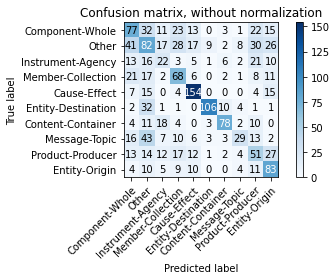

In [16]:
plot_confusion_matrix(y__test,np.array(y_pred),np.array(labels_n))
plt.show()
